# 1.- Introduction

## 1.1 Project description

The telecommunications operator Interconnect would like to be able to predict its customer cancellation rate. If a user is found to be planning to leave, promotional codes and special plan options will be offered. Interconnect’s marketing team has collected some of their customers' personal data, including information about their plans and contracts.

#### Interconnect Services.

Interconnect provides two main types of services:

1. Communication by landline. The phone can be connected to several lines simultaneously. 
2. Internet. The network can be set up via a telephone line (DSL, *digital subscriber line*) or via a fiber optic cable. 

Some other services offered by the company include:. 
- Internet security: antivirus software (*Dispositive Protection*) and a malicious website blocker (*SeguridEnLínea*). 
- A technical support line (*SoporteTécnico*).. - Cloud file storage and data backup (*BackupOnline*).. 
- TV streaming (*StreamingTV*) and movie directory (*StreamingPelículas*). 

Customers can choose between a monthly payment or signing a 1- or 2-year contract. You can use multiple payment methods and receive an electronic invoice after a transaction.

## 1.2 Data description

The data consists of files obtained from different sources:

- `contract.csv`- contract information;
- `personal.csv` - customer’s personal data;
- `internet.csv` information about Internet services;
- `phone.csv` - information about telephone services.

In each file, the `customerID` column contains a unique code assigned to each client. The contract information is valid as of February 1, 2020.

# 2.- Loading and data preprocessing

In [32]:
# Libraries importation
import pandas as pd
import numpy as np
import re
import random

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.metrics import roc_auc_score

In [33]:
# Useful function to use
def standardize_column_names(dataframe):
    """
    This function standardizes the name of columns in datasets.
    Convert names to lower case and separate words by lower script.
    Args:
        dataframe: is the set of data to obtain the name of columns and be able to standardize them.
    Return:
        the function prints the new name of columns after the standardized process.
    """
    # Select the culumns from dataframe
    column_names = dataframe.columns
    # Create an empty list to save the new names after the standarize process
    standard_column_names = []
    for item in column_names:
        item = re.sub('(.)([A-Z][a-z]+)', r'\1_\2', item)
        standard_column_names.append(re.sub('([a-z0-9])([A-Z])', r'\1_\2', item).lower())
    # manually change customerID column
    #standard_column_names[0] = 'customer_id'
    # Change the name of the dataframe's column to the new set
    dataframe.columns = standard_column_names
    # Print the new columns names
    print(dataframe.columns)

import sklearn.metrics as metrics
def evaluate_model(model, train_features, train_target, test_features, test_target):

    eval_stats = {}

    fig, axs = plt.subplots(1, 3, figsize=(20, 6))

    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):

        eval_stats[type] = {}

        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]

        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]

        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps

        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # Valor F1
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # Establish crossings for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'Valor F1')

        # ROC
        ax = axs[1]
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # Establish crossings for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')
        ax.set_title(f'Curva ROC')

        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # Establish crossings for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)

    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))

    print(df_eval_stats)

    return

## 2.1 Loading and preprocessing of contract.csv file

In [34]:
# Loading contract.csv file
contract_df = pd.read_csv(r'C:\Users\paul_\OneDrive\Documentos\Python Scripts\ml_model_to_predict_customer_cancellation_rate\contract.csv')
contract_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


In [35]:
print(f'Null values: \n{contract_df.isnull().sum()}')
print(f'\nDuplicated values: {contract_df.duplicated().sum()}')

Null values: 
customerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
dtype: int64

Duplicated values: 0


In [36]:
# First 5 rows visualization
contract_df.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


**Observation**: The *contract.csv* file contains 7,043 values and 8 columns. It does not contain null or duplicate data. Of the 8 columns, 7 are of type object and one of type float however, the BeginDate column will be converted to date type for easier work. Regarding the EndDate column, we will leave it as an object since the column contains values like 'No' which means that the client is still active. The TotalCharges column, I will later convert it to the float type so that I can work with it. Finally, the names of the features will have to be standardized, that is, they will have to be written in lower case and words separated by means of low script.

In [37]:
# Calling standardize_column_names function
standardize_column_names(contract_df)

Index(['customer_id', 'begin_date', 'end_date', 'type', 'paperless_billing',
       'payment_method', 'monthly_charges', 'total_charges'],
      dtype='object')


**Observation**: Trying to change the data type from *total_charges* from object to float64, I discovered that the column had some blank data that pandas doesn’t recognize as null, blanks. So I will have to try to see if the data can be obtained from somewhere else and also look for blank spaces in some other column.

In [38]:
contract_df[contract_df['total_charges']==' ']

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,


**Observation**: Apparently, these blanks are because the clients started their contract on February 1, 2020, so they have not received any payment yet. These blank spaces could be changed to zeroes since there has been no charge so far.

In [39]:
for item in contract_df.columns:
    if contract_df[item].dtypes=='object' and (item!='total_charges' and item!='customer_id'):
        print(contract_df[item].unique())

['2020-01-01' '2017-04-01' '2019-10-01' '2016-05-01' '2019-09-01'
 '2019-03-01' '2018-04-01' '2019-04-01' '2017-07-01' '2014-12-01'
 '2019-01-01' '2018-10-01' '2015-04-01' '2015-09-01' '2018-01-01'
 '2014-05-01' '2015-10-01' '2014-03-01' '2018-05-01' '2019-11-01'
 '2019-02-01' '2016-01-01' '2017-08-01' '2015-12-01' '2014-02-01'
 '2018-06-01' '2019-12-01' '2017-11-01' '2019-06-01' '2016-04-01'
 '2017-02-01' '2018-12-01' '2014-04-01' '2018-09-01' '2014-11-01'
 '2016-07-01' '2015-02-01' '2018-07-01' '2014-08-01' '2016-03-01'
 '2018-08-01' '2014-10-01' '2015-06-01' '2016-08-01' '2019-05-01'
 '2017-03-01' '2016-02-01' '2017-09-01' '2014-09-01' '2017-12-01'
 '2016-12-01' '2017-06-01' '2015-05-01' '2016-10-01' '2016-09-01'
 '2019-08-01' '2019-07-01' '2017-05-01' '2017-10-01' '2014-07-01'
 '2018-03-01' '2015-01-01' '2018-11-01' '2015-03-01' '2018-02-01'
 '2016-06-01' '2015-08-01' '2015-11-01' '2014-06-01' '2017-01-01'
 '2015-07-01' '2020-02-01' '2016-11-01' '2013-11-01' '2014-01-01'
 '2013-10-

In [40]:
# Change white spaces for zeros
contract_df['total_charges'] = contract_df['total_charges'].where(contract_df['total_charges'] != ' ', '0.00')

contract_df[contract_df['total_charges']==' ']

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges


In [41]:
contract_df[contract_df['begin_date']=='2020-02-01']

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,0.00
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,0.00
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,0.00
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,0.00
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,0.00
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,0.00
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,0.00
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,0.00
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,0.00
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,0.00


In [42]:
# Change data type for total_changes var to float64
contract_df['total_charges'] = pd.to_numeric(contract_df['total_charges'])

In [43]:
# Convert begin_date column to pandas datetime
contract_df['begin_date'] = pd.to_datetime(contract_df['begin_date'], format='%Y-%m-%d')
print(f"Data type of contract_df dataframe: \n{contract_df.dtypes.value_counts()}")

Data type of contract_df dataframe: 
object            5
float64           2
datetime64[ns]    1
Name: count, dtype: int64


In [44]:
contract_df.head()

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.50
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


## 2.2 Loading and preprocessing of internet.csv file

In [45]:
# Loading internet.csv file
internet_df = pd.read_csv(r'C:\Users\paul_\OneDrive\Documentos\Python Scripts\ml_model_to_predict_customer_cancellation_rate\internet.csv')
internet_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [46]:
print(f'Null values: \n{internet_df.isnull().sum()}')
print(f'\nDuplicated values: {internet_df.duplicated().sum()}')

Null values: 
customerID          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
dtype: int64

Duplicated values: 0


In [47]:
# First 5 rows visualization
internet_df.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


**Observation**: In this set, I can see that there are only 5,517 values, corresponding to 5,517 clients who hired the internet service. I could deduce that there are customers who do not have an internet service, only telephony. This set contains 8 columns, no duplicate nor null values. All characteristics are of the object type, and looking at the data the data type is correct and does not require any change; the only change will be the name of the columns, standardising them as in the previous case.

In [48]:
# Calling standardize_column_names function
standardize_column_names(internet_df)

Index(['customer_id', 'internet_service', 'online_security', 'online_backup',
       'device_protection', 'tech_support', 'streaming_tv',
       'streaming_movies'],
      dtype='object')


In [49]:
# Print unique values for each column
for item in internet_df.columns:
    if internet_df[item].dtypes=='object' and item!='customer_id':
        print(item,':',internet_df[item].unique())

internet_service : ['DSL' 'Fiber optic']
online_security : ['No' 'Yes']
online_backup : ['Yes' 'No']
device_protection : ['No' 'Yes']
tech_support : ['No' 'Yes']
streaming_tv : ['No' 'Yes']
streaming_movies : ['No' 'Yes']


**Observation**: In this set I have no blank spaces that could be omitted by pandas when searching for null values.

## 2.3 Loading and preprocessing of personal.csv file

In [50]:
# Loading personal.csv file
personal_df = pd.read_csv(r'C:\Users\paul_\OneDrive\Documentos\Python Scripts\ml_model_to_predict_customer_cancellation_rate\personal.csv')
personal_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [51]:
print(f'Null values: \n{personal_df.isnull().sum()}')
print(f'\nDuplicated values: {personal_df.duplicated().sum()}')

Null values: 
customerID       0
gender           0
SeniorCitizen    0
Partner          0
Dependents       0
dtype: int64

Duplicated values: 0


In [52]:
# First 5 rows
personal_df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


**Observation**: In this data set I see 7043 data each corresponding to a single customer who has services contracted with the telecommunications company. There are 5 columns, of which 4 are of the object type and one of them int64 type. You would have to check the data in that column to see if it really should be of type int64 or it will have to be convert to object type. No null nor duplicate values. 

In [53]:
# Calling standardize_column_names function
standardize_column_names(personal_df)

Index(['customer_id', 'gender', 'senior_citizen', 'partner', 'dependents'], dtype='object')


In [54]:
# Print unique values for each column
for item in personal_df.columns:
    if item!='customer_id':
        print(item,':',personal_df[item].unique())

gender : ['Female' 'Male']
senior_citizen : [0 1]
partner : ['Yes' 'No']
dependents : ['No' 'Yes']


**Observation**: Apparently the senior_citizen column has only values of 0 and 1, which I would assume it would correspond to 'No' and 'Yes'. The change could be made through a relationship, in order to have a better type of data when building and training the model.

In [55]:
# Change from binary to logic data
for i in range(len(personal_df)):
    personal_df.loc[i, 'senior_citizen_logic'] = 'Yes' if personal_df.loc[i, 'senior_citizen'] == 1 else 'No'
# Show the result
personal_df.sample(5)

,customer_id,gender,senior_citizen,partner,dependents,senior_citizen_logic
1932,3247-MHJKM,Male,0,No,No,No
192,2984-RGEYA,Female,0,Yes,Yes,No
5246,1981-INRFU,Female,0,No,No,No
6101,4627-MIHJH,Female,1,No,No,Yes
512,5956-VKDTT,Female,1,Yes,No,Yes


In [56]:
print(f"Data type of contract_df dataframe: \n{personal_df.dtypes.value_counts()}")

Data type of contract_df dataframe: 
object    5
int64     1
Name: count, dtype: int64


## 2.4 Loading and preprocessing of phone.csv file

In [57]:
# Loading phone.csv file
phone_df = pd.read_csv(r'C:\Users\paul_\OneDrive\Documentos\Python Scripts\ml_model_to_predict_customer_cancellation_rate\phone.csv')
phone_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


In [58]:
print(f'Null values: \n{phone_df.isnull().sum()}')
print(f'\nDuplicated values: {phone_df.duplicated().sum()}')

Null values: 
customerID       0
MultipleLines    0
dtype: int64

Duplicated values: 0


In [59]:
# First 5 rows from dataframe
phone_df.head()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


**Observation**: In this set, I see only 6,361 data, no null nor duplicate values, and only two columns. Of the 7,043 customers, only 6,361 have a telephone line. The data types are correct and should be checked for any blank spaces as in the first set of data.

In [60]:
# Calling standardize_column_names function 
standardize_column_names(phone_df)

Index(['customer_id', 'multiple_lines'], dtype='object')


In [61]:
# Show unique values of each column
phone_df['multiple_lines'].unique()

array(['No', 'Yes'], dtype=object)

**Observación**: The *multiple_lines* column has only two options: 'No' and 'Yes' which corresponds to whether the client has more than one contracted phone line or not. Apparently everything is fine with this data set and the information it contains.

Next, I will perform a merge in order to have a single set of data that I can use for the construction and training of our prototype model. Before that, let’s create our target, that is, let’s create a new column from the 'end_date' column, in the contract_df data set, in which I will map the information of the column exist in binary form, in other words, the new column will be 0 and 1, where 0 means that the client is still active and 1 means otherwise, the client’s contract is terminated.

In [62]:
# Map the information in the 'end_date' column of the contract_df set to binary form, 0s and 1s.
for i in range(len(contract_df)):
    contract_df.loc[i, 'end_date_binary'] = 0 if contract_df.loc[i, 'end_date'] == 'No' else 1

contract_df['end_date_binary'] = contract_df['end_date_binary'].astype('int64')
contract_df.head()

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,end_date_binary
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,0
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.50,0
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,1
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,0
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,1


**Observation**: I will add a new column to the table indicating the number of years that the user has with the contracted service. If end_date is 'No' it means the user is still active so I will use the date of February 1, 2020 which is the date when data was obtained.

In [ ]:
# Calculate the years the client has been with the service in a new column
for i in range(len(contract_df)):
    contract_df.loc[i, 'years_as_client'] = (2020 - contract_df.loc[i, 'begin_date'].year) if contract_df.loc[i, 'end_date'] == 'No' else (pd.to_datetime(contract_df.loc[i, 'end_date'], format='%Y-%m-%d %H:%M:%S').year - contract_df.loc[i, 'begin_date'].year)

contract_df['years_as_client'] = contract_df['years_as_client'].astype('int64')

In [64]:
# Show the dataframe first 5 rows
contract_df.head()

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,end_date_binary,years_as_client
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,0,0
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.50,0,3
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,1,0
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,0,4
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,1,0


**Observation**: Now I already have an accountant of how many years the client has been with the service. Let’s hope this new column improves the results of the models.

In [65]:
# Performs a merge of the sets to obtain a final set with all information
merged_df = personal_df.merge(contract_df, on='customer_id', how='outer')
# Remove the 'senior_citizen' and 'end_date' columns from the final set since we have 'senior_citizen_logic' and 'end_date_binary' instead.
merged_df.drop(labels=['senior_citizen', 'end_date'], axis='columns', inplace=True)
# Merges data from the remaining sets
merged_df = merged_df.merge(internet_df, on='customer_id', how='left')
merged_df = merged_df.merge(phone_df, on='customer_id', how='left')

# Rename the columns 'senior_citizen_logic' and 'end_date_binary' to 'senior_citizen' and 'target', respectively.
new_columns = {'senior_citizen_logic': 'senior_citizen', 'end_date_binary': 'target'}
merged_df.rename(columns=new_columns, inplace=True)

merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   gender             7043 non-null   object        
 2   partner            7043 non-null   object        
 3   dependents         7043 non-null   object        
 4   senior_citizen     7043 non-null   object        
 5   begin_date         7043 non-null   datetime64[ns]
 6   type               7043 non-null   object        
 7   paperless_billing  7043 non-null   object        
 8   payment_method     7043 non-null   object        
 9   monthly_charges    7043 non-null   float64       
 10  total_charges      7043 non-null   float64       
 11  target             7043 non-null   int64         
 12  years_as_client    7043 non-null   int64         
 13  internet_service   5517 non-null   object        
 14  online_s

**Observation**: I have already merged all the information into a final set with all the data to be used for the model. However, as noted, I have zero values. These values were not caused by an omission of the client or intentionally, these values indicate that the client does not have a contracted internet or telephone service. In other words, the customer may have contracted an internet and/or telephone service.

For the processing of these null values, I will proceed as follows: I will replace the null values of the 'internet_service' and 'multiple_lines' columns with the word 'Nonexistent', since, There are customers who do not have an internet and/or telephone service contracted, so there is no such service for them. For the rest of the columns, I will replace the null values with the 'No' option since they do not have it

In [66]:
# Replace missing values ​​in the columns 'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv' and 'streaming_movies' with 'No'
columns_to_fillna = ['online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies']
for column in columns_to_fillna:
    merged_df.fillna({column: 'No'}, inplace=True)

merged_df.fillna({'multiple_lines': 'Nonexistent'}, inplace=True)
merged_df.fillna({'internet_service': 'Nonexistent'}, inplace=True)

In [67]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   gender             7043 non-null   object        
 2   partner            7043 non-null   object        
 3   dependents         7043 non-null   object        
 4   senior_citizen     7043 non-null   object        
 5   begin_date         7043 non-null   datetime64[ns]
 6   type               7043 non-null   object        
 7   paperless_billing  7043 non-null   object        
 8   payment_method     7043 non-null   object        
 9   monthly_charges    7043 non-null   float64       
 10  total_charges      7043 non-null   float64       
 11  target             7043 non-null   int64         
 12  years_as_client    7043 non-null   int64         
 13  internet_service   7043 non-null   object        
 14  online_s

In [68]:
print(f'Número de valores nulos: \n{merged_df.isnull().sum()}')
print(f'\nNúmero de valores duplicados: {merged_df.duplicated().sum()}')

Número de valores nulos: 
customer_id          0
gender               0
partner              0
dependents           0
senior_citizen       0
begin_date           0
type                 0
paperless_billing    0
payment_method       0
monthly_charges      0
total_charges        0
target               0
years_as_client      0
internet_service     0
online_security      0
online_backup        0
device_protection    0
tech_support         0
streaming_tv         0
streaming_movies     0
multiple_lines       0
dtype: int64

Número de valores duplicados: 0


In [69]:
merged_df.sample(10)

,customer_id,gender,partner,dependents,senior_citizen,begin_date,type,paperless_billing,payment_method,monthly_charges,...,target,years_as_client,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
3328,4741-WWJQZ,Female,Yes,No,No,2019-12-01,Month-to-month,Yes,Electronic check,80.15,...,0,1,Fiber optic,Yes,No,No,Yes,No,No,No
5082,7138-GIRSH,Male,No,No,No,2015-12-01,Two year,No,Bank transfer (automatic),69.50,...,0,5,DSL,No,No,Yes,Yes,No,Yes,Yes
459,0674-DGMAQ,Male,Yes,No,Yes,2017-06-01,Month-to-month,Yes,Electronic check,93.50,...,0,3,Fiber optic,No,Yes,Yes,No,No,Yes,Yes
3549,5028-GZLDO,Male,No,No,No,2019-09-01,Month-to-month,No,Credit card (automatic),70.70,...,1,0,Fiber optic,No,No,No,No,No,No,No
2302,3295-YVUSR,Male,No,No,Yes,2019-12-01,Month-to-month,Yes,Mailed check,72.60,...,0,1,Fiber optic,No,No,No,No,No,No,Yes
4494,6340-DACFT,Female,Yes,Yes,No,2015-12-01,Two year,No,Credit card (automatic),20.55,...,0,5,Nonexistent,No,No,No,No,No,No,No
4181,5913-INRQV,Male,Yes,No,Yes,2017-04-01,One year,No,Mailed check,90.15,...,0,3,Fiber optic,Yes,No,No,Yes,Yes,No,No
1221,1810-BOHSY,Male,Yes,No,No,2015-11-01,One year,Yes,Credit card (automatic),96.40,...,0,5,Fiber optic,Yes,Yes,No,No,No,Yes,Yes
2461,3522-CDKHF,Female,Yes,No,No,2017-06-01,Month-to-month,Yes,Bank transfer (automatic),75.50,...,0,3,Fiber optic,Yes,No,No,No,No,No,No
738,1087-UDSIH,Female,No,No,No,2019-08-01,Month-to-month,Yes,Mailed check,19.60,...,1,0,Nonexistent,No,No,No,No,No,No,No


**Observation**: Finally I have the final set with which I will work, I can see that it does not have missing nor duplicate values. Now I will move on to the process of exploratory data analysis (EDA) to review the information from the set before model construction.

# 3.- Exploratory Data Analysis (EDA)

In [70]:
# Select columns by type
categoric_columns = [item for item in merged_df.columns if merged_df[item].dtypes=='object' and item!='customer_id']
numeric_columns = [item for item in merged_df.columns if merged_df[item].dtypes in ('int64', 'float64') and item!='target']

print(f'Características categóricas: {categoric_columns}')
print(f'\nCaracterísticas numéricas: {numeric_columns}')

Características categóricas: ['gender', 'partner', 'dependents', 'senior_citizen', 'type', 'paperless_billing', 'payment_method', 'internet_service', 'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies', 'multiple_lines']

Características numéricas: ['monthly_charges', 'total_charges', 'years_as_client']


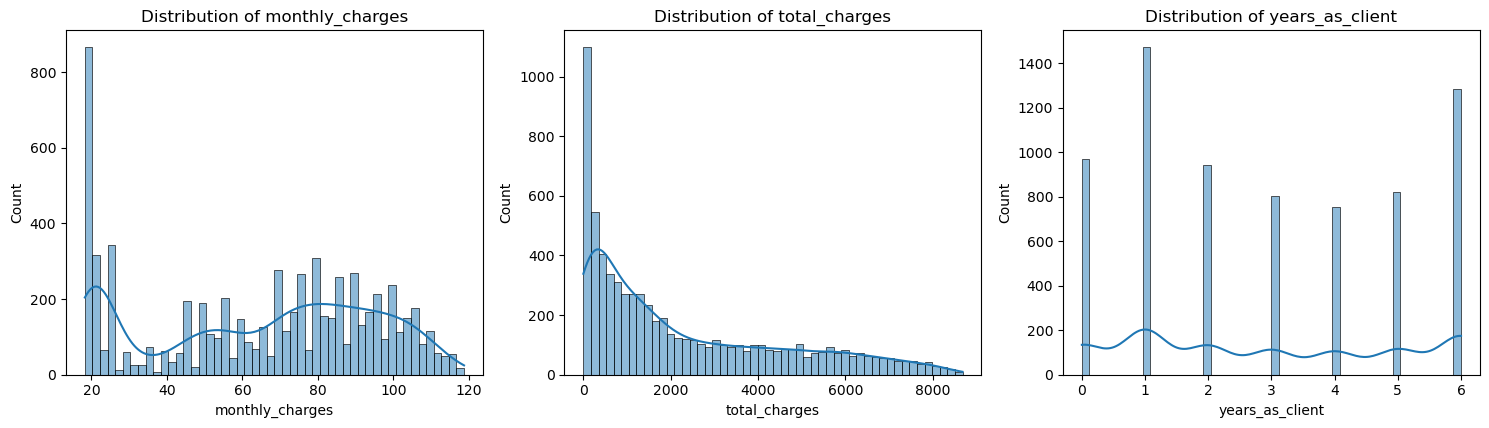

In [71]:
# Numerical columns distribution visualization
plt.figure(figsize=(15, 12))
for i, col in enumerate(numeric_columns, start=1):
    plt.subplot(3, 3, i)
    sns.histplot(merged_df[col], kde=True, bins=50)
    plt.title(f"Distribution of {col}")
    
plt.tight_layout()
plt.show()

In [72]:
merged_df[['monthly_charges', 'total_charges', 'years_as_client']].describe()

,monthly_charges,total_charges,years_as_client
count,7043.000000,7043.000000,7043.000000
mean,64.761692,2279.734304,2.921340
std,30.090047,2266.794470,2.101257
min,18.250000,0.000000,0.000000
25%,35.500000,398.550000,1.000000
50%,70.350000,1394.550000,3.000000
75%,89.850000,3786.600000,5.000000
max,118.750000,8684.800000,6.000000


**Observation**: The distribution of monthly charges seems to have a negative bias, the average is on the left of the median, however, at first glance it is not very easy to deduce this. This means that the monthly charge of 50% of clients is above average, which is ~  $65. In the case of total charges, the graph reflects an asymmetry to the right. Users have paid less than $2,000 since subscribing to some service. Nevertheless, there are users who have paid more than $8,000 to date. It can also be seen that 50% of customers have three years with the service to date, the maximum number of years is 6.

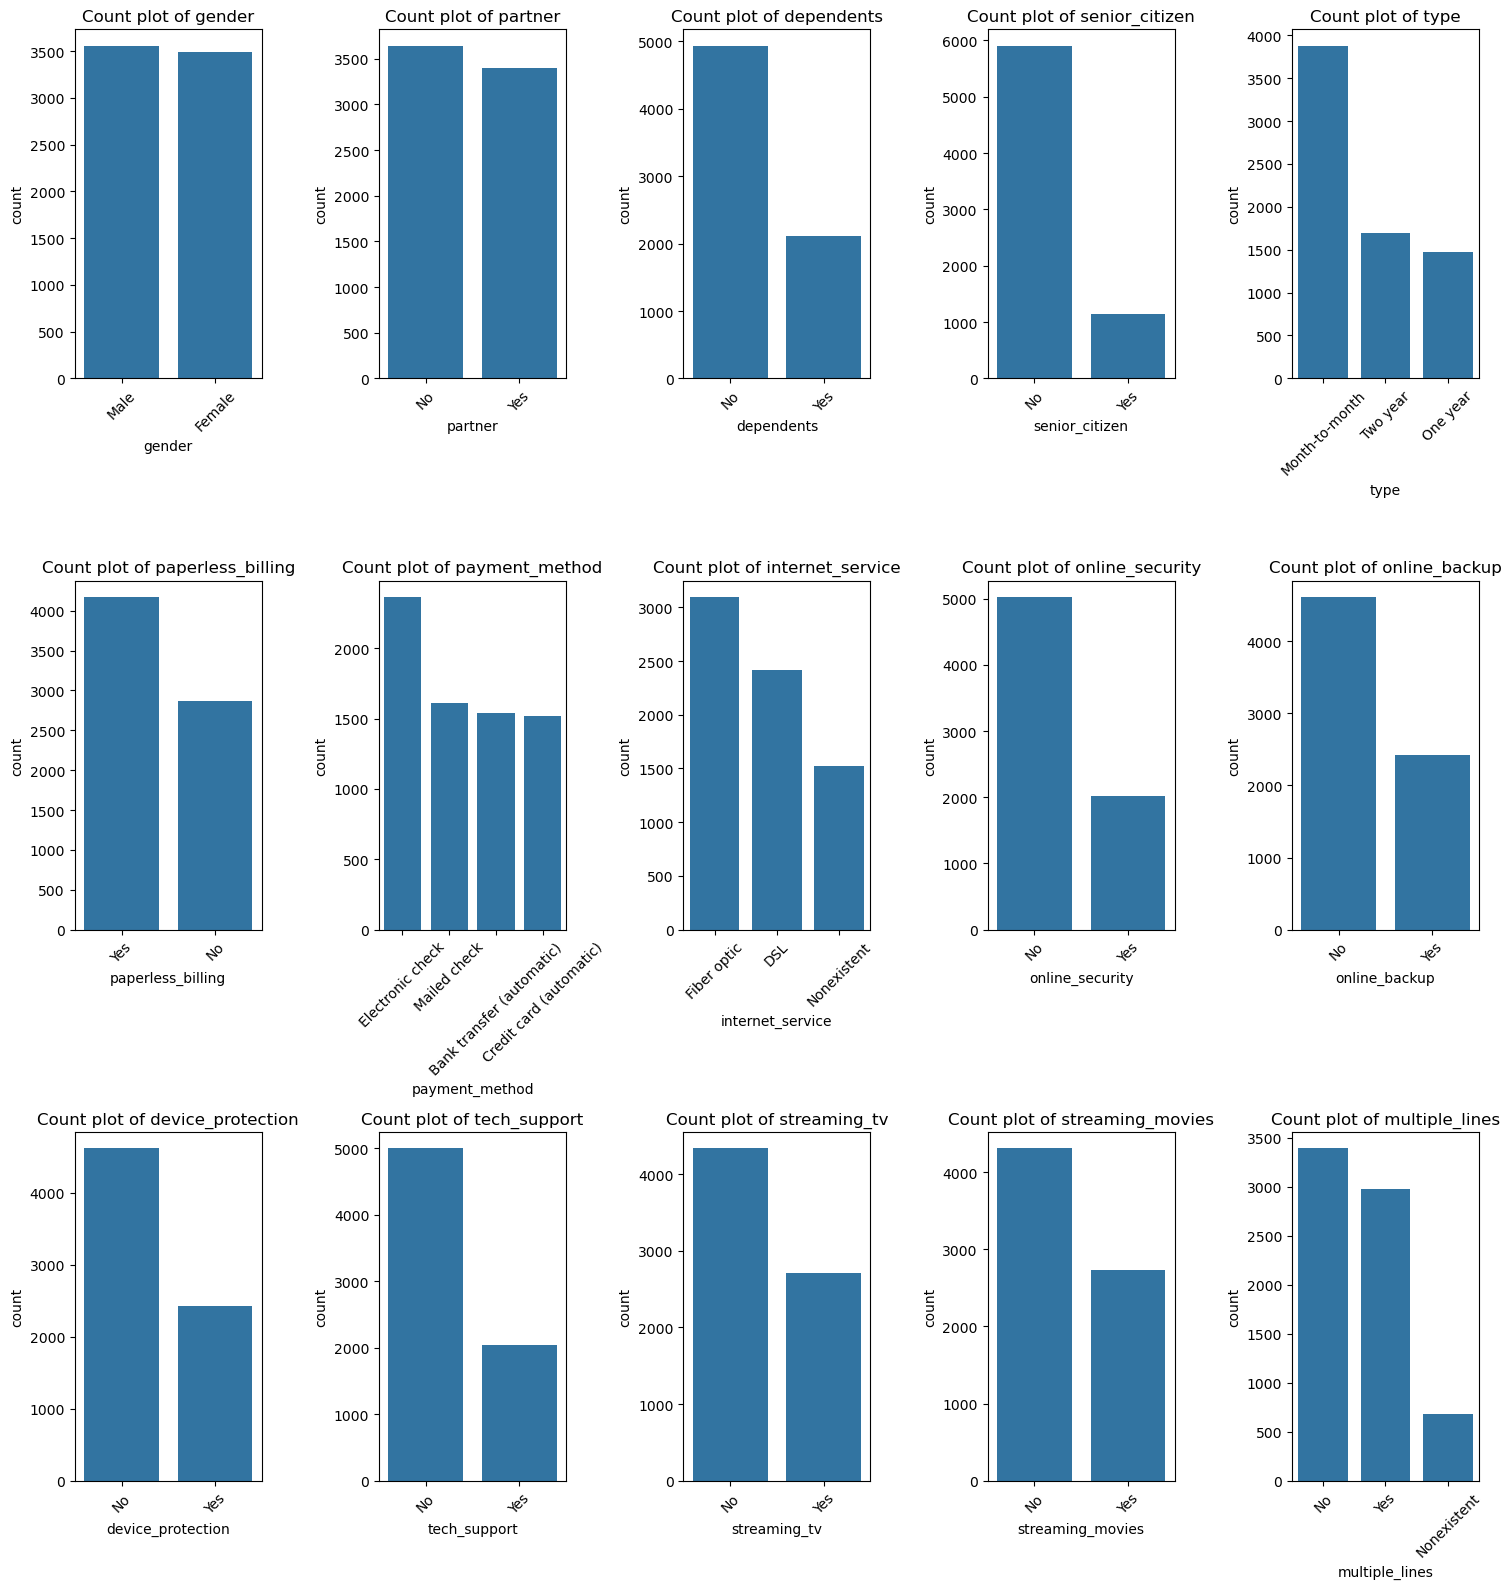

target
0    5174
1    1869
Name: count, dtype: int64


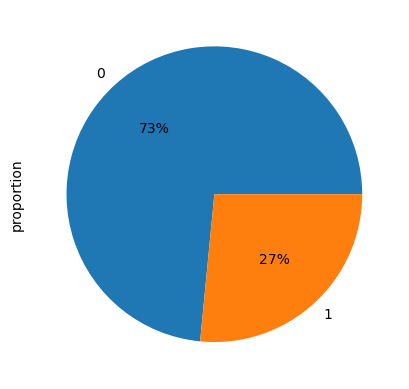

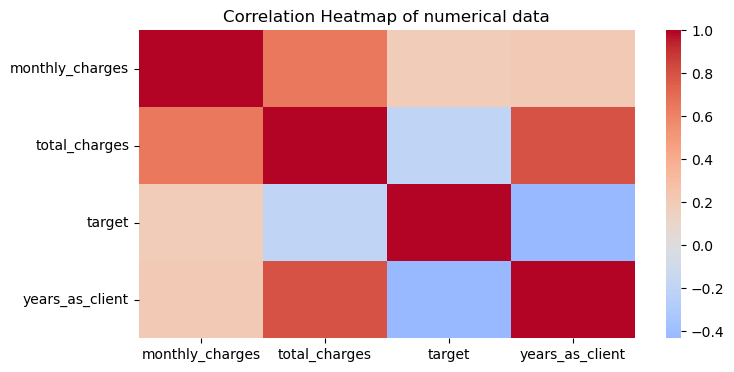

In [73]:
# Categorical columns analysis
plt.figure(figsize=(15, 16))
for i, col in enumerate(categoric_columns, start=1):
    plt.subplot(3, 5, i)
    sns.countplot(data=merged_df, x=col, order=merged_df[col].value_counts().index)
    plt.title(f"Count plot of {col}")
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Verify the unbalanced of classes with value_counts()
print(merged_df['target'].value_counts())
merged_df['target'].value_counts(normalize=True).plot(kind='pie', autopct='%.0f%%')

# Correlation heatmap
plt.figure(figsize=(8, 4))
corr = merged_df.select_dtypes(include=['int64', 'float64']).corr()
sns.heatmap(corr, cmap='coolwarm', center=0)
plt.title("Correlation Heatmap of numerical data")
plt.show()

**Observation**: There is a slightly higher number of female clients compared to male clients however the difference seems to be minimal. Most customers are partners, however, as in the previous case, there is a minimal difference between those who are partners and those who are not. Finally, 70% of clients have dependents, I assume that most of their dependents are children. In case this is correct, there may be a point to focus on since the marketing or promotion strategy may vary depending on the employees.

With respect to senior_citizen, the graph shows that there is a big difference, where the vast majority, more than 80% of clients, are retired. Regarding the type of contract, 55% of clients prefer an annual contract, compared to paying month by month or a two-year contract. Finally, approximately two-thirds have e-billing enabled.

One-third of users pay by postal check, the remaining two-thirds by e-check, credit card or bank transfer. It is important to emphasize that 21% of users do not have a contracted internet service, the remaining 79%, their majority has contracted a DSL service compared to fiber optic. The vast majority, more than two-thirds of consumers, do not have an online security service.

65% have a cloud storage service. The same number of users do not have a device protection, that is, an antivirus software and finally, almost 71% of consumers own a contracted technical support service. Almost 2/3 of customers have a contracted TV streaming service; and on the other hand, the same number of users do not have a movie streaming service. Finally, 682 users do not have a contracted telephone service and those who do, slightly less than 50% do not have multiple lines.

There is a class imbalance, obviously, the information shows more people who still have the service than those who no longer have it. This is important to know because a class imbalance can affect our model, so it is essential to know this fact. Finally, in the last graph of the correlation map of the numerical data, it shows that monthly charges have a small correlation in the target, if not to total charges or years with the service users have.

# 4.- Modeling

## 4.1- Creation of the objective and characteristics along with the division of the data set into training and validation.

In [74]:
# Target selection
target = merged_df['target']

# Features selection
features = merged_df.drop(['customer_id', 'target', 'begin_date'], axis=1)
features.head()

,gender,partner,dependents,senior_citizen,type,paperless_billing,payment_method,monthly_charges,total_charges,years_as_client,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
0,Female,Yes,Yes,No,One year,Yes,Mailed check,65.6,593.30,1,DSL,No,Yes,No,Yes,Yes,No,No
1,Male,No,No,No,Month-to-month,No,Mailed check,59.9,542.40,1,DSL,No,No,No,No,No,Yes,Yes
2,Male,No,No,No,Month-to-month,Yes,Electronic check,73.9,280.85,1,Fiber optic,No,No,Yes,No,No,No,No
3,Male,Yes,No,Yes,Month-to-month,Yes,Electronic check,98.0,1237.85,2,Fiber optic,No,Yes,Yes,No,Yes,Yes,No
4,Female,Yes,No,Yes,Month-to-month,Yes,Mailed check,83.9,267.40,0,Fiber optic,No,No,No,Yes,Yes,No,No


In [75]:
# Separate of dataset into training and validation sets
features_train, features_valid, target_train, target_valid = train_test_split(features, target, test_size=0.25, random_state=42)

## 4.2 Models and parameters adjustments

### 4.2.1 Constant model

In [76]:
from sklearn.dummy import DummyClassifier

In [77]:
model_0 = DummyClassifier(strategy='most_frequent')
model_0.fit(features_train, target_train)

,strategy,'most_frequent'
,random_state,None
,constant,None


          train  test
Accuracy   0.73  0.74
F1         0.00  0.00
APS        0.27  0.26
ROC AUC    0.50  0.50


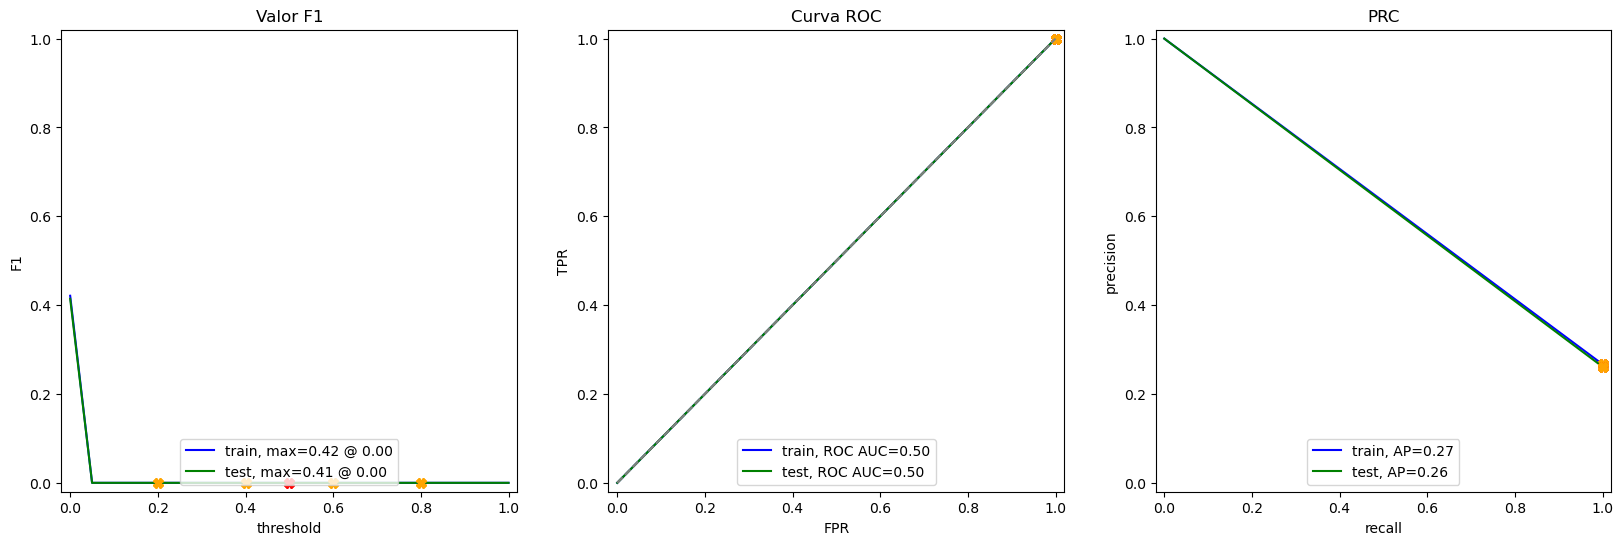

In [78]:
evaluate_model(model_0, features_train, target_train, features_valid, target_valid)

### 4.2.1 Logistic Regression model

In [79]:
# Creation of a features preprocessing object
preprocessor_lr = ColumnTransformer(transformers=[
    ('numerical', StandardScaler(), numeric_columns),
    ('categorical', OneHotEncoder(drop='first', sparse_output=False), categoric_columns)
])

In [80]:
# Training the logistic regression model
lr_model = LogisticRegression(class_weight='balanced', random_state=42)
# Create a parameters grid
param_grid = {
    'solver': ['liblinear', 'newton-cholesky', 'newton-cg', 'lbfgs'],
    'max_iter': [100, 500, 1000],
    'C': [0.01, 0.1, 0.5, 1],
    'penalty': ['l1', 'l2', 'elasticnet', None]
}

In [81]:
# Create a GridSearchCV object for hyperparameters adjustment
grid_search = GridSearchCV(
    estimator=lr_model, 
    param_grid=param_grid, 
    cv=5, 
    scoring='roc_auc',
    n_jobs=-1
)

In [82]:
# Create a pipeline for feature preprocessing followed by hyperparameter adjustment
clf = Pipeline(steps=[('preprocessor', preprocessor_lr), ('gridsearchcv', grid_search)])
# Train the model
clf.fit(features_train, target_train)

c:\Users\paul_\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:516: FitFailedWarning: 
480 fits failed out of a total of 960.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\paul_\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\paul_\anaconda3\Lib\site-packages\sklearn\base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\paul_\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py", line 1218, in fit
    solver =

,steps,"[('preprocessor', ...), ('gridsearchcv', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('numerical', ...), ('categorical', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [83]:
# Save the metrics along with the parameters
lr_model_best_parms = grid_search.best_params_
lr_model_best_score = grid_search.best_score_

print(f"Mejores parámetros: {lr_model_best_parms}")
print(f"Mejor puntaje cross-validation: {lr_model_best_score:.2f}")

Mejores parámetros: {'C': 0.5, 'max_iter': 100, 'penalty': 'l1', 'solver': 'liblinear'}
Mejor puntaje cross-validation: 0.89


In [84]:
# LogisticRegression() model with final parameters
LogReg_model = LogisticRegression(C=0.5, max_iter=100, penalty='l1', solver='liblinear', class_weight='balanced', random_state=42)

          train  test
Accuracy   0.79  0.80
F1         0.68  0.68
APS        0.79  0.78
ROC AUC    0.90  0.89


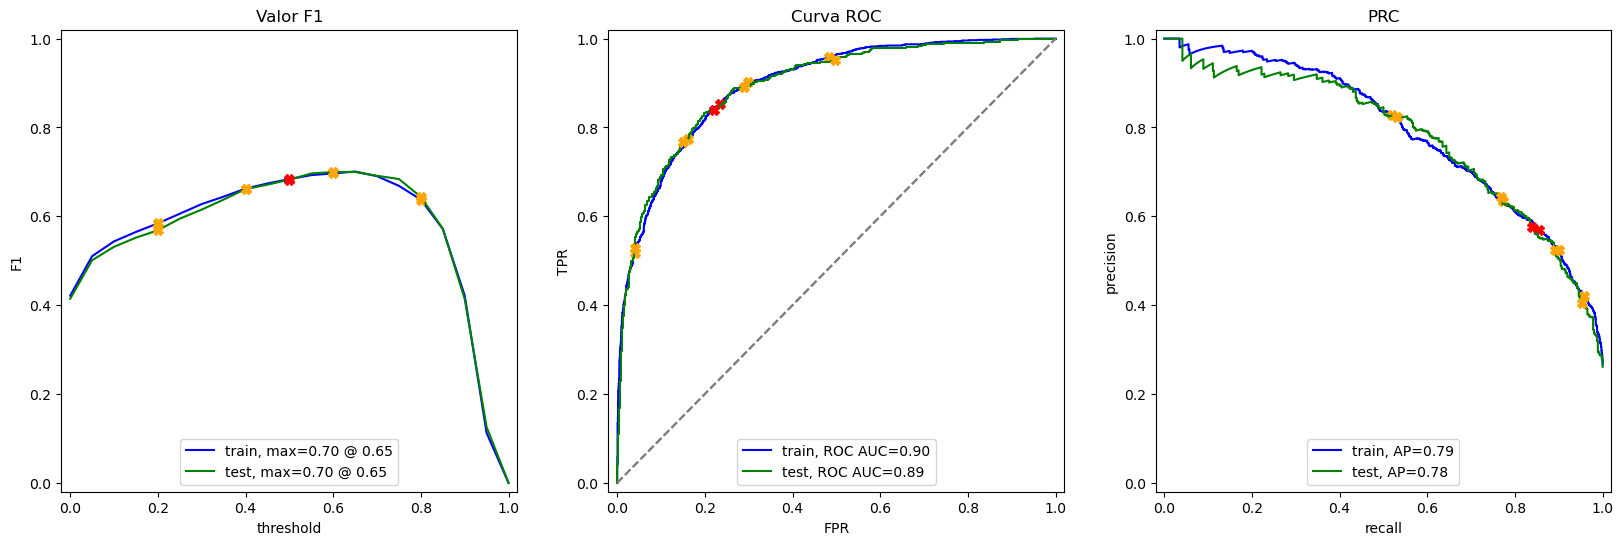

In [85]:
# Create a pipeline for preprocessing of features
clf_LR = Pipeline(steps=[('preprocessor', preprocessor_lr), ('model', LogReg_model)])
clf_LR.fit(features_train, target_train)
# Calculate the metrics for the validation set
evaluate_model(clf_LR, features_train, target_train, features_valid, target_valid)

**Observation**: The Logistic Regression model gives a ROC_AUC score of 0.9 with the training set and 0.89 with the validation set.

### 4.2.2 Random Forest Classifier model

In [86]:
# Create a preprocessing object
preprocessor_rfc = ColumnTransformer(transformers=[
    ('numerical', StandardScaler(), numeric_columns)
    #('categorical', OneHotEncoder(drop='first', sparse_output=False), categoric_columns)
])

In [87]:
# Encode categorical variables with label encoding
le = LabelEncoder()
features_train_rfc = features_train.copy()
for col in categoric_columns:
    features_train_rfc[col] = le.fit_transform(features_train[col])

In [88]:
# Create a random forest model
rfc_model = RandomForestClassifier(class_weight='balanced', random_state=42)
# Create a parameters grid
param_grid = {
    'n_estimators': [50, 100, 200, 1000],
    'max_depth': [None, 10, 15, 20, 100],
    'max_leaf_nodes': [None, 50, 100, 200, 1000],
    'max_samples': [100, 200, 1000]
}

In [89]:
# Create a GridSearchCV object for hyperparameters adjustment
grid_search = GridSearchCV(
    estimator=rfc_model, 
    param_grid=param_grid, 
    cv=5,
    scoring='roc_auc',
    n_jobs=-1
)

In [90]:
# Create a pipeline for feature preprocessing followed by hyperparameter adjustment
clf = Pipeline(steps=[('preprocessor', preprocessor_rfc), ('gridsearchcv', grid_search)])
# Train the model
clf.fit(features_train_rfc, target_train)

,steps,"[('preprocessor', ...), ('gridsearchcv', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('numerical', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [91]:
# Save the metrics along with the parameters
rfc_model_best_parms = grid_search.best_params_
rfc_model_best_score = grid_search.best_score_

print(f"Mejores parámetros: {rfc_model_best_parms}")
print(f"Mejor puntaje en el cross-validation: {rfc_model_best_score:.2f}")

Mejores parámetros: {'max_depth': 15, 'max_leaf_nodes': None, 'max_samples': 1000, 'n_estimators': 1000}
Mejor puntaje en el cross-validation: 0.90


In [92]:
# RandomForestClassifier() model with final parameters
model_RFC = RandomForestClassifier(max_depth=15, max_leaf_nodes=None, max_samples=1000, n_estimators=1000, class_weight='balanced', random_state=42)

In [93]:
# Encode the validation set categorical variables with label encoding
features_valid_rfc = features_valid.copy()
for col in categoric_columns:
    features_valid_rfc[col] = le.fit_transform(features_valid[col])

          train  test
Accuracy   0.91  0.88
F1         0.81  0.73
APS        0.93  0.83
ROC AUC    0.97  0.90


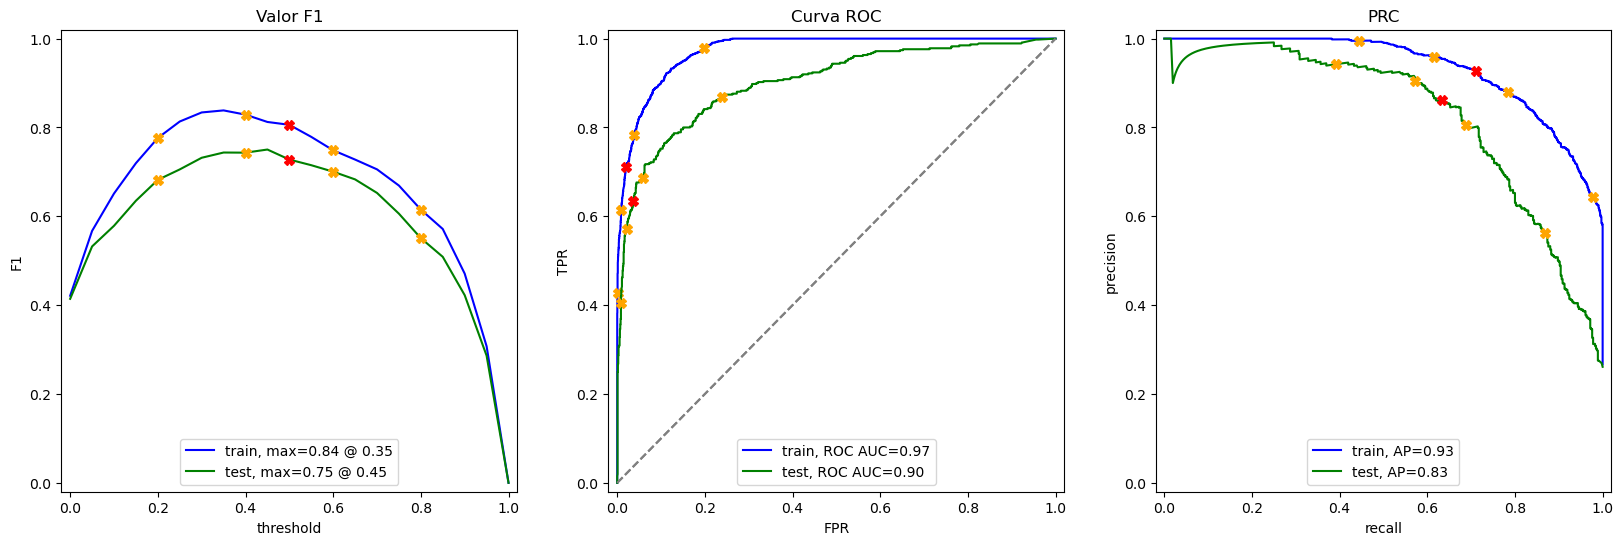

In [94]:
# Create a pipeline for features preprocessing
clf_RFC = Pipeline(steps=[('preprocessor', preprocessor_rfc), ('model', model_RFC)])
clf_RFC.fit(features_train_rfc, target_train)
# Calculate metrics for validation set
evaluate_model(clf_RFC, features_train_rfc, target_train, features_valid_rfc, target_valid)

**Observation**: Although the results and metrics of the model are good, there seems to be an overfitting, it has better results with the training set than with the validation set.

### 4.2.3 Decision Tree Classifier model

In [95]:
# Create a preprocessing object
preprocessor_dtc = ColumnTransformer(transformers=[
    ('numerical', StandardScaler(), numeric_columns)
    #('categorical', OneHotEncoder(drop='first', sparse_output=False), categoric_columns)
])

In [96]:
# Encode categorical variables with label encoding
le = LabelEncoder()
features_train_dtc = features_train.copy()
for col in categoric_columns:
    features_train_dtc[col] = le.fit_transform(features_train[col])

In [97]:
# Create a DecisionTreeClassifier model
dtc_model = DecisionTreeClassifier(class_weight='balanced', random_state=42)

# Create a parameters grid 
param_grid = {
    'max_depth': [9, 10, 11],
    'min_samples_split': [6, 7, 8],
    'max_leaf_nodes': [30, 50, 70],
    'min_samples_leaf': [1, 2, 3],
    'min_weight_fraction_leaf': [0.001, 0.005, 0.007]
}

In [98]:
# Create a GridSearchCV object for parameters adjustment
grid_search = GridSearchCV(
    estimator=dtc_model, 
    param_grid=param_grid, 
    cv=5, 
    scoring='roc_auc',
    n_jobs=-1
)

In [99]:
# Create a pipeline for feature preprocessing followed by hyperparameter adjustment
clf = Pipeline(steps=[('preprocessor', preprocessor_dtc), ('gridsearchcv', grid_search)])
# Train the model
clf.fit(features_train_dtc, target_train)

,steps,"[('preprocessor', ...), ('gridsearchcv', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('numerical', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [100]:
# Save the metrics along with the parameters
dtc_model_best_parms = grid_search.best_params_
dtc_model_best_score = grid_search.best_score_

print(f"Mejores parámetros: {dtc_model_best_parms}")
print(f"Mejor puntuación en el cross-validation: {dtc_model_best_score:.2f}")

Mejores parámetros: {'max_depth': 11, 'max_leaf_nodes': 70, 'min_samples_leaf': 1, 'min_samples_split': 6, 'min_weight_fraction_leaf': 0.005}
Mejor puntuación en el cross-validation: 0.89


In [101]:
# DecisionTreeClassifier() model with final parameters
model_DTC = DecisionTreeClassifier(max_depth=11, max_leaf_nodes=70, min_samples_leaf=1, min_samples_split=6, 
                                   min_weight_fraction_leaf=0.005, class_weight='balanced', random_state=42)

In [102]:
# Encode categorical variables with label encoding
features_valid_dtc = features_valid.copy()
for col in categoric_columns:
    features_valid_dtc[col] = le.fit_transform(features_valid[col])

          train  test
Accuracy   0.91  0.88
F1         0.81  0.73
APS        0.93  0.83
ROC AUC    0.97  0.90


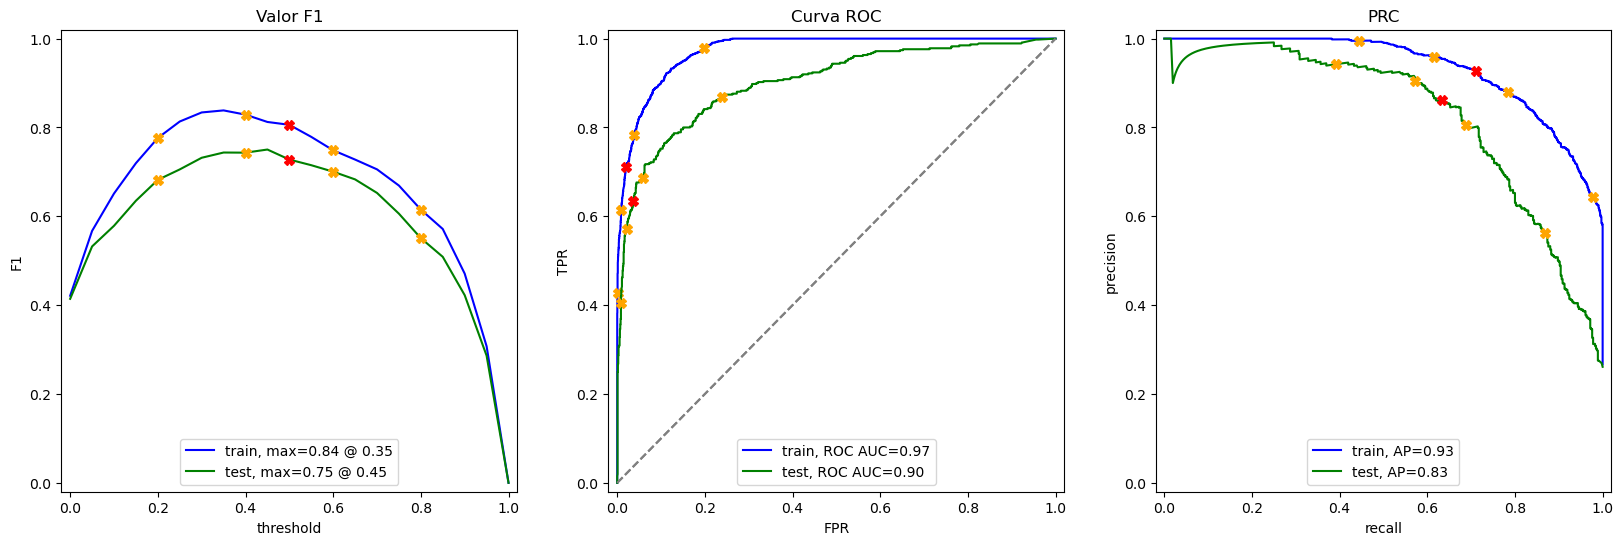

In [103]:
# Create a pipeline for features preprocessing
clf_DTC = Pipeline(steps=[('preprocessor', preprocessor_dtc), ('model', model_DTC)])
clf_RFC.fit(features_train_dtc, target_train)
# Calculate the metrics for validation set
evaluate_model(clf_RFC, features_train_dtc, target_train, features_valid_dtc, target_valid)

**Observation**: It seems to be the same case in this model, the results indicate that the model fit the training set very well, however, the metrics for the validation set are high.

### 4.2.4 LightGBM Classifier model

**Observation**: For the LightGBM and CatBoost models, it is not necessary to code the categorical characteristics since both gradient enhancement models have their own tools that handle the categorical characteristics directly, so we will use the information without giving a pre-processing. However, for LightGBM it is necessary to change the data type from categorical characteristics to 'category' type for the model to work.

In [104]:
# Change the object’s variable type to a category for the lightgbm model
features_train_lgbm = features_train.copy()
for c in categoric_columns:
    features_train_lgbm[c] = features_train_lgbm[c].astype('category')

In [105]:
# Create a preprocessing object for numerical features
preprocessor_lgbm = ColumnTransformer(transformers=[('numerical', StandardScaler(), numeric_columns)])

In [106]:
# Create a LightGBM model
lgbm_model = LGBMClassifier(class_weight='balanced', random_state=42)

# Create a parameters grid
param_grid = {
    'num_leaves': [9, 10, 11],
    'max_depth': [7, 8, 9],
    'min_data_in_leaf': [87, 90, 93],
    'learning_rate': [0.3, 0.5, 0.7],
    'n_estimators': [101, 105, 107]
}

In [107]:
# Create a GridSearchCV object
grid_search = GridSearchCV(
    estimator=lgbm_model, 
    param_grid=param_grid, 
    cv=5,
    scoring='roc_auc',
    n_jobs=-1
)

In [108]:
# Create a pipeline for feature preprocessing followed by hyperparameter adjustment
clf = Pipeline(steps=[('preprocessor', preprocessor_lgbm), ('gridsearchcv', grid_search)])
# Train the model
clf.fit(features_train_lgbm, target_train)

[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93
[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93
[LightGBM] [Info] Number of positive: 1409, number of negative: 3873
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000192 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 518
[LightGBM] [Info] Number of data points in the train set: 5282, number of used features: 3
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


,steps,"[('preprocessor', ...), ('gridsearchcv', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('numerical', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [109]:
# Save the metrics and parameters
lgbm_model_best_parms = grid_search.best_params_
lgbm_model_best_score = grid_search.best_score_

print(f"Mejores parámetros: {lgbm_model_best_parms}")
print(f"Mejor puntuación en el cross-validation: {lgbm_model_best_score:.2f}")

Mejores parámetros: {'learning_rate': 0.3, 'max_depth': 9, 'min_data_in_leaf': 93, 'n_estimators': 105, 'num_leaves': 10}
Mejor puntuación en el cross-validation: 0.90


In [110]:
# LGBMClassifier() model with final parameters
LightGBM_model = LGBMClassifier(learning_rate=0.3, max_depth=9, min_data_in_leaf=93, n_estimators=105, 
                                num_leaves=10, class_weight='balanced', random_state=42)

[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93
[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93
[LightGBM] [Info] Number of positive: 1409, number of negative: 3873
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000168 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 518
[LightGBM] [Info] Number of data points in the train set: 5282, number of used features: 3
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93
[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93
[LightGBM] [Warning] min_

c:\Users\paul_\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\paul_\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\paul_\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\paul_\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


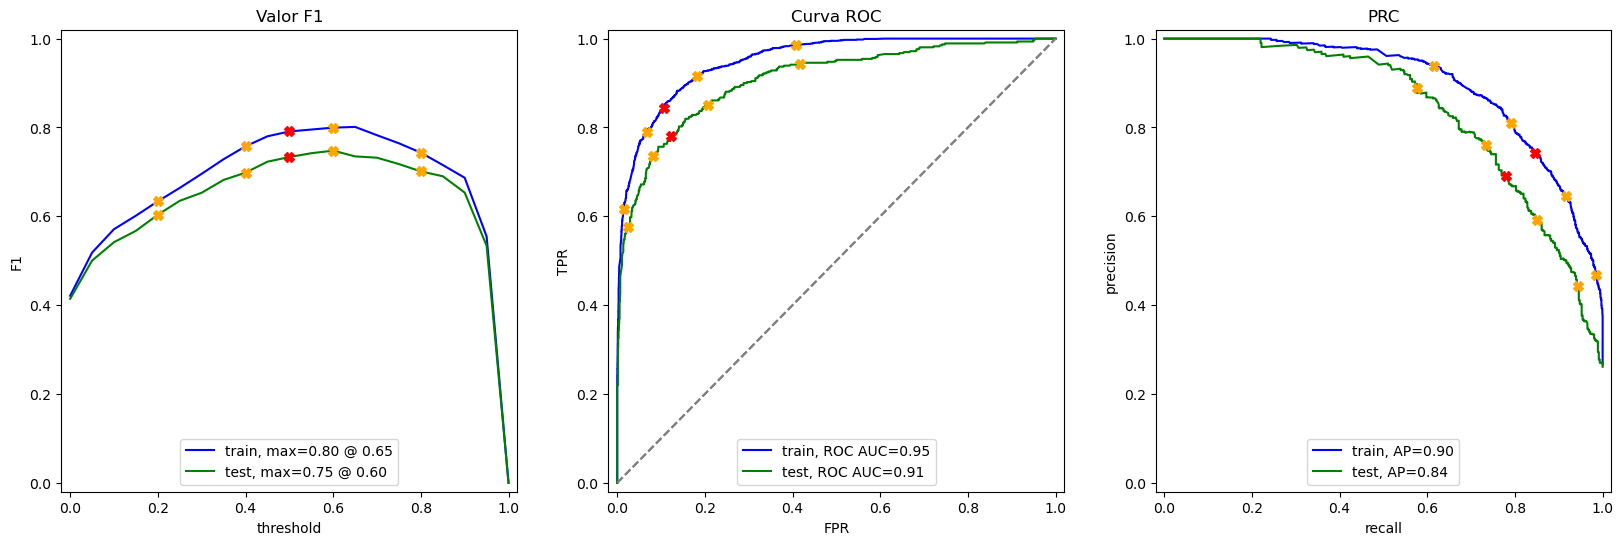

In [111]:
# Create a pipeline for features preprocessing
clf_lgbm = Pipeline(steps=[('preprocessor', preprocessor_lgbm), ('model', LightGBM_model)])
clf_lgbm.fit(features_train, target_train)
# Calculate the metrics for validation set
evaluate_model(clf_lgbm, features_train, target_train, features_valid, target_valid)

**Observation**: In this case, there is a bit of over-tuning; however, the results of the model with the validation set and the training set are very similar. Means that the model does not have such a marked overfit as in the two previous models. The results with this model are very good.

### 4.2.5 XGBoost Classifier model

In [112]:
# Create a preprocessing object
preprocessor_xgbc = ColumnTransformer(transformers=[
    ('numerical', StandardScaler(), numeric_columns),
    ('categorical', OneHotEncoder(drop='first', sparse_output=False), categoric_columns)
])

In [113]:
# Create a XGBClassifier model
xgb_model = XGBClassifier(scale_pos_weight=(target_train.value_counts()[0]/target_train.value_counts()[1]), eval_metric='auc', random_state=42)

# Create a parameters grid
param_grid = {
    'n_estimators': [100, 200, 500],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [5, 10, 15],
    'subsample': [0.1, 0.5, 0.9]
}

In [114]:
# Create a GridSearchCV model
grid_search = GridSearchCV(
    estimator=xgb_model, 
    param_grid=param_grid, 
    cv=5,
    scoring='roc_auc',
    n_jobs=-1
)

In [115]:
# Create a pipeline for feature preprocessing followed by hyperparameter adjustment
clf = Pipeline(steps=[('preprocessor', preprocessor_xgbc), ('gridsearchcv', grid_search)])
# Train the model
clf.fit(features_train, target_train)

c:\Users\paul_\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:1135: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan]
  warnings.warn(


,steps,"[('preprocessor', ...), ('gridsearchcv', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('numerical', ...), ('categorical', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [116]:
# Save the metrics and the parameters
xgbc_model_best_parms = grid_search.best_params_
xgbc_model_best_score = grid_search.best_score_

print(f"Mejores parámetros: {xgbc_model_best_parms}")
print(f"Mejor puntuación en el cross-validation: {xgbc_model_best_score:.2f}")

Mejores parámetros: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.1}
Mejor puntuación en el cross-validation: nan


In [118]:
# XGBClassifier() model with final parameters
XGBC_model = XGBClassifier(max_depth=5, n_estimators=100, learning_rate=0.01, subsample=0.1,
                           scale_pos_weight=(target_train.value_counts()[0]/target_train.value_counts()[1]), 
                           eval_metric='auc', random_state=42)

          train  test
Accuracy   0.82  0.81
F1         0.70  0.68
APS        0.81  0.78
ROC AUC    0.91  0.89


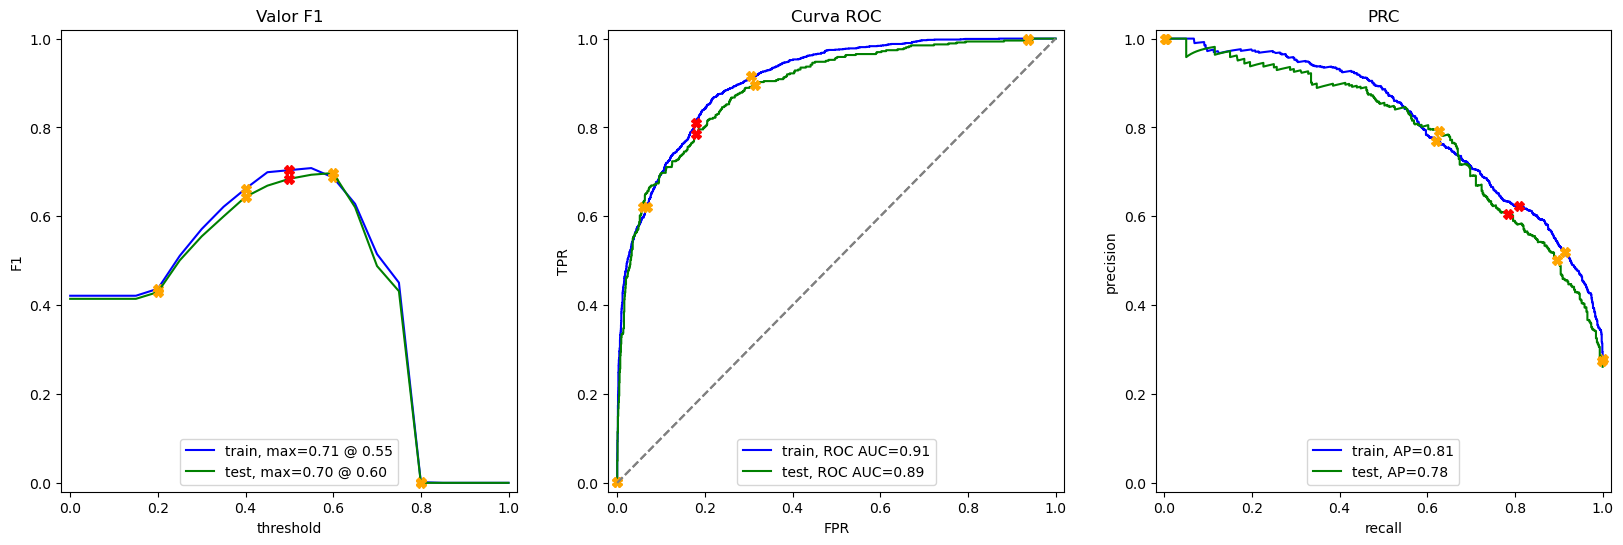

In [119]:
# Create a pipeline for features preprocessing
clf_XGBC = Pipeline(steps=[('preprocessor', preprocessor_xgbc), ('model', XGBC_model)])
clf_XGBC.fit(features_train, target_train)
# Calculate the metrics for validation set
evaluate_model(clf_XGBC, features_train, target_train, features_valid, target_valid)

**Observation**: The model results are high, both the metric of ROC_AUC and the accuracy have very high values which indicates that the model yields good predictions.

# 5.- Conclusions

All models performed excellently, however the RandomForestClassfier and DecisionTreeClassifier models had a more marked overfit. However, the overfit was not high, just a 0.06 difference in ROC_AUC metrics. The LogisticRegression, XGBClassifier and LGBMClassifier models performed very well in both sets and the overfit was lower, 0.01 and 0.04, respectively, in the ROC_AUC metric. Having added the years column as a user improved the model result since, when modeling was carried out without the data, the metrics in the training set did not exceed 0.85 of ROC_AUC.

Finally, if it were possible to add a new data on the number of complaints from each client over the years that the contracted service has had could be a good idea and help the model since, if the service fails too much, the client will very likely terminate the contract.